En esta v2 simplemente he añadido una capa lineal más entre la capa lstm y la capa lineal de salida. Quedaría probar si un dropout me cambia en algo

In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_mt as rrnn
import multitask_dep as mt

import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']
encoding_type = 'brk'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [6]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab,word_to_index) 

In [7]:
convai_train_dataset =rrnn.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False,deps=True)

In [8]:
convai_val_dataset = rrnn.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab,word_to_index) 


md_dataset  = rrnn.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train =  DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_val = DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)
dl_eval  = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# MultiTask SGD

In [12]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [13]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_sgd_brk'

In [14]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.4810606060606061, 'as': 0.48370273794002605, 'about': 0.5102040816326531}
Accuracy evaluando en etiquetas female
{'to': 1.0, 'as': 1.0, 'about': 1.0}
Accuracy evaluando en etiquetas male
{'to': 0.0, 'as': 0.0, 'about': 0.0}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.079492896691432 	 Validation loss: 2.079225257291632 	 
  1%|          | 574/57400 [00:06<09:46, 96.91it/s]
Epoch 2 	 Training loss: 2.0767134639859615 	 Validation loss: 2.0801143040091303 	 
  2%|▏         | 1148/57400 [00:13<09:50, 95.19it/s]
Epoch 3 	 Training loss: 2.076389545762996 	 Validation loss: 2.080298387398154 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:30, 97.55it/s]
Epoch 4 	 Training loss: 2.0763373802763243 	 Validation loss: 2.081337613574529 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:34, 95.98it/s]
Epoch 5 	 Training loss: 2.075989999422213 	 Validation loss: 2.0810509697865633 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:32<09:18, 97.56it/s]
Epoch 6 	 Training loss: 2.076217273386513 	 Validation loss: 2.0827506154270496 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:38<09:10, 97.95it/s]
Epoch 7 	 Training loss: 2.075975746227889 	 Validation loss: 2.

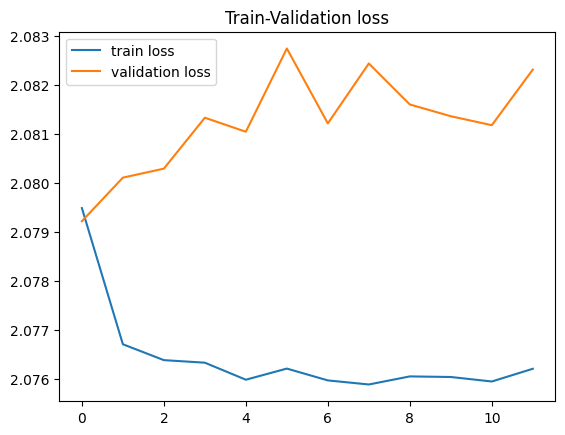

In [15]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [16]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5214646464646465, 'as': 0.5189048239895697, 'about': 0.4923469387755102}
Accuracy evaluando en etiquetas female
{'to': 0.015748031496062992, 'as': 0.02425876010781671, 'about': 0.0125}
Accuracy evaluando en etiquetas male
{'to': 0.9902676399026764, 'as': 0.9823232323232324, 'about': 0.9921875}


# AdamW

In [17]:
model = rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_multi_adamw_brk'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.075726660286508 	 Validation loss: 2.079708180185092 	 
  1%|          | 574/57400 [00:07<11:02, 85.81it/s]
Epoch 2 	 Training loss: 2.0731007134872863 	 Validation loss: 2.076421325489626 	 
  2%|▏         | 1148/57400 [00:14<10:48, 86.69it/s]
Epoch 3 	 Training loss: 2.069788922000845 	 Validation loss: 2.072224091675322 	 
  3%|▎         | 1722/57400 [00:21<10:52, 85.40it/s]
Epoch 4 	 Training loss: 2.0666150062341724 	 Validation loss: 2.075035774101645 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:29<10:29, 87.53it/s]
Epoch 5 	 Training loss: 2.064611343141217 	 Validation loss: 2.071179458650492 	 
  5%|▌         | 2870/57400 [00:36<10:36, 85.71it/s]
Epoch 6 	 Training loss: 2.063843169694163 	 Validation loss: 2.0685923948126326 	 
  6%|▌         | 3444/57400 [00:43<10:27, 85.96it/s]
Epoch 7 	 Training loss: 2.0619932180497704 	 Validation loss: 2.068799265360428 	 
  7%|▋         | 4018/57400 [00:50<10:34, 84.17it/s]
Epoch 8 	 Traini

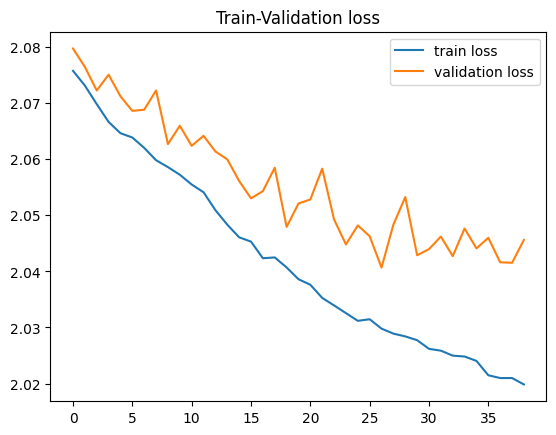

In [18]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [19]:
model =  rrnn.MultiTaskRRNNDep(emb_dim,vocab,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5214646464646465, 'as': 0.5840938722294654, 'about': 0.6466836734693877}
Accuracy evaluando en etiquetas female
{'to': 0.5879265091863517, 'as': 0.6657681940700808, 'about': 0.66}
Accuracy evaluando en etiquetas male
{'to': 0.45985401459854014, 'as': 0.5075757575757576, 'about': 0.6328125}
